In [1]:
import numpy as np
import pysindy as ps
import h5py, tqdm
from tqdm import trange
from sklearn.linear_model import LinearRegression
import func_timeout
import warnings
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import random
warnings.filterwarnings("ignore", category=UserWarning)
random.seed(42)
np.random.seed(42)

## 1. Data preparation and model training

### Load in data and preprocess

In [2]:
n_data = 3000
d = h5py.File("data\\ref_data_train.jld", "r")
ref_data = d['ref_data_train'][:]
ref_params = d['ref_params_train'][:]
t = d['times_train'][:]
times = t.copy()
dt = 60

In [3]:
ref_param = np.empty((len(ref_params), 9))
for i in range(len(ref_params)):
    for j in range(9):
        ref_param[i,j] = ref_params[i][j]
ref_params = ref_param

In [4]:
EO = 300
ref_data[:,:,0] = EO * ref_data[:,:,0]

### PCA

In [5]:
# Importing standardscalar module 
from sklearn.preprocessing import StandardScaler
  
scalar = StandardScaler(with_std=False)
reshaped_data = np.concatenate([ref_data[i] for i in range(ref_data.shape[0])])
# fitting
scalar.fit(reshaped_data)
scaled_data = scalar.transform(reshaped_data)



# Importing PCA
from sklearn.decomposition import PCA
pca = PCA(n_components = 3)
pca.fit(scaled_data)
x_pca = [pca.transform(scaled_data[i*48: i*48+48, :]) for i in range(ref_data.shape[0])]
x = np.concatenate(x_pca)

In [6]:
sum(pca.explained_variance_ratio_)

0.9999395925549887

In [7]:
data = x_pca

### Construct libraries for E-SINDy

In [8]:
### define function for hv and emission along time
def hv_func(hv_shift, t):
    hv_1 = max(np.sin((t + 1500 + hv_shift) / 720 * np.pi - np.pi / 2), 0)
    hv_2 = max((np.sin((t + 1500 + hv_shift) / 720 * np.pi - np.pi / 2)+1.0)/2, 0)
    return np.array([hv_1 * 0.9 + hv_2 * 0.1])

def emission_func(const, init_shift, t):
    return 0.95*const + 0.05*const*np.sin((t +1500) /(1440/2)*np.pi - init_shift)

In [9]:
depositions =     np.array([-0.4/(100*12) * 60, 
    -4/(100*15)* 60,
    -0.5/(100*2) * 60,
    -0.1/(100*2) * 60,
    -0.03/2 * 60,
    -0.1/100 * 60]).reshape(1,6)

In [10]:
# Combine control variables with data
multi_U = []
for i in range(n_data):
    p = np.repeat(ref_params[i,0], t.shape[0])
    T = np.repeat(ref_params[i,1], t.shape[0])
    Tp =p*T
    depo = np.repeat(depositions, t.shape[0], axis=0)
    hv = np.concatenate([hv_func( ref_params[i,-1], ti) for ti in t-1500])
    emission1 = 0.0005 * np.stack([emission_func( ref_params[i,2], ref_params[i,5], ti) for ti in t-1500])
    emission2 = 0.0001 * np.stack([emission_func( ref_params[i,3],  ref_params[i,6], ti) for ti in t-1500])
    emission3 = 0.0008 * np.stack([emission_func( ref_params[i,4],  ref_params[i,7], ti) for ti in t-1500])
    multi_U.append(np.hstack((emission1.reshape(-1,1), emission2.reshape(-1,1), emission3.reshape(-1,1), depo, hv.reshape(-1,1), Tp.reshape(-1,1))))

# Custome library for U
poly_library = ps.PolynomialLibrary(degree=4, include_bias=False)
library_functions = [lambda x: x]
library_function_names = [
    lambda x: x
]

# lib for emissions
custom_library1 = ps.CustomLibrary(
    library_functions=library_functions, 
    function_names=library_function_names
)

# lib for other parameters
custom_library2 = ps.CustomLibrary(
    library_functions=library_functions, 
    function_names=library_function_names
)

inputs_temp = np.tile([i for i in range(14)], 3)
inputs_per_library = np.reshape(inputs_temp, (3, 14))
inputs_per_library[0, 3:] = 2
inputs_per_library[1, :3] = 3
inputs_per_library[1, 12:] = 11
inputs_per_library[2, :12] = 12
print(inputs_per_library)

tensor_array = [[1, 0, 1]]

generalized_library = ps.GeneralizedLibrary(
    [poly_library, custom_library1, custom_library2],
    tensor_array=tensor_array,
    inputs_per_library=inputs_per_library,
)

feature_names = ["pc1", "pc2", "pc3", "emission_NO2", "emission_HCHO", "emission_H2O2", "depo1","depo2","depo3","depo4", "depo5", "depo6", "hv", "p*T"]
optimizer = ps.STLSQ(threshold=1e-5)
u = np.concatenate(multi_U)
model = ps.SINDy()
dx= np.concatenate(model.differentiate(data, t=dt, multiple_trajectories=True))
generalized_library.fit(np.hstack((x, u)))
lib = generalized_library.transform(np.hstack((x, u)))

[[ 0  1  2  2  2  2  2  2  2  2  2  2  2  2]
 [ 3  3  3  3  4  5  6  7  8  9 10 11 11 11]
 [12 12 12 12 12 12 12 12 12 12 12 12 12 13]]


### Training ensemble model...

In [11]:
# ensemble = True
# lib_ensemble = True
# n_subset = int(0.3 * n_data * 48)
# n_candidates_to_drop = 30
# ensemble_coef = []
# n_features = lib.shape[1]
# COEF_THRESHOLD = 1e-14
# n_models = 1000
# for i in trange(n_models):
#     coef = np.zeros((3, n_features))
#     if ensemble:
#         rand_inds = np.random.choice(range(n_data * 48), n_subset, replace=False)
#         lib_new = np.take(lib, rand_inds, axis=0)
#         dx_new = np.take(dx, rand_inds, axis=0)
#     else:
#         lib_new = lib
#         dx_new = dx
#     if lib_ensemble:
#         keep_inds = np.sort(np.random.choice(range(n_features), n_features - n_candidates_to_drop, replace=False))
#         lib_new = lib_new.take(keep_inds, axis=1)
#     else:
#         keep_inds = range(n_features)

#     optimizer.fit(lib_new, dx_new)
#     coef[:, keep_inds] = optimizer.coef_
#     # Unbias part
#     ind_ = np.abs(coef) > COEF_THRESHOLD
#     coef__ = np.zeros(coef.shape)
#     for i in range(ind_.shape[0]):
#         if np.any(ind_[i]):
#             coef__[i, ind_[i]] = (LinearRegression(fit_intercept=False).fit(lib[:, ind_[i]], dx[:, i]).coef_)
#     ensemble_coef.append(coef__)

In [12]:
# np.save("result\\ensemble_coef_ESINDy_newdata_30per_row_30_col_depo_NO2.npy", ensemble_coef)
with open('result\\ensemble_coef_ESINDy_newdata_30per_row_30_col_depo_NO2.npy', 'rb') as f:
    ensemble_coef = np.load(f)

### Define inference function with numba for speedup

In [13]:
from numbalsoda import lsoda_sig, lsoda, dop853
import numba as nb

def make_lsoda_func(param):
    @nb.cfunc(lsoda_sig)
    def rhs(t, u, du, p):
        y = nb.carray(u, (3,))
        p_ = nb.carray(p, (8,))
        x0 = y[0]
        x1 = y[1]
        x2 = y[2]

        ## 4th order polynomial
        y_ = np.array([x0, x1, x2, x0**2, x0*x1, x0*x2, x1**2, x1*x2, x2**2, x0**3, x0**2*x1, 
              x0**2*x2, x0*x1**2, x0*x1*x2, x0*x2**2, x1**3, x1**2*x2, x1*x2**2, 
              x2**3, x0**4, x0**3*x1, x0**3*x2, x0**2*x1**2, x0**2*x1*x2, x0**2*x2**2, 
              x0*x1**3, x0*x1**2*x2, x0*x1*x2**2, x0*x2**3, x1**4, x1**3*x2, x1**2*x2**2, x1*x2**3, x2**4])
        hv_shift = p_[-1]
        hv_1 = max(np.sin((t + 1500 + hv_shift) / 720 * np.pi - np.pi / 2), 0)
        hv_2 = max((np.sin((t + 1500 + hv_shift) / 720 * np.pi - np.pi / 2)+1.0)/2, 0)
        hv = np.array([hv_1 * 0.9 + hv_2 * 0.1])

        pT = np.array([p_[6]])
        emission1 = p_[0]
        emission2 = p_[1]
        emission3 = p_[2]
        emission1_shift = p_[3]
        emission2_shift = p_[4]
        emission3_shift = p_[5]
        emission1 = 0.0005* np.array([0.95*emission1 + 0.05*emission1*np.sin((t +1500) /(1440/2)*np.pi - emission1_shift)])
        emission2 = 0.0001* np.array([0.95*emission2 + 0.05*emission2*np.sin((t +1500) /(1440/2)*np.pi - emission2_shift)])
        emission3 = 0.0008* np.array([0.95*emission3 + 0.05*emission3*np.sin((t +1500) /(1440/2)*np.pi - emission3_shift)])
        depos = np.array([-0.4/(100*12) * 60, -4/(100*15)* 60,-0.5/(100*2) * 60,-0.1/(100*2) * 60,-0.03/2 * 60,-0.1/100 * 60])
        ## interleave combinations of hv, p, T with y_
        temp = np.empty(len(y_)*2)
        for idx, (item1, item2) in enumerate(zip(hv*y_, pT*y_)):
            temp[idx*2] = item1
            temp[idx*2+1] = item2

        θ = np.concatenate((y_, emission1,emission2, emission3, depos, hv, pT, temp))
        du[0] = np.sum(param[0,:]*θ)
        du[1] = np.sum(param[1,:]*θ)
        du[2] = np.sum(param[2,:]*θ)
    return rhs


In [14]:
d_valid = h5py.File("data\\ref_data_validate.jld", "r")
ref_params_valid = d_valid['ref_params_validate'][:]
ref_data_valid = d_valid['ref_data_validate'][:]
times_valid = d_valid['times_validate'][:]

ref_param = np.empty((len(ref_params_valid), 9))
for i in range(len(ref_params_valid)):
    for j in range(9):
        ref_param[i,j] = ref_params_valid[i][j]
ref_params_valid = ref_param
ref_data_valid[:,:,0] = EO * ref_data_valid[:,:,0]
multi_U_valid = []
    
for i in range(ref_params_valid.shape[0]):
    p = ref_params_valid[i][0]
    T = ref_params_valid[i][1]
    pT = p*T
    multi_U_valid.append(np.concatenate((ref_params_valid[i][2:8], [pT], [ref_params_valid[i][-1]]), axis = 0))
reshaped_data_valid = np.concatenate([ref_data_valid[i] for i in range(ref_data_valid.shape[0])])
scaled_data_valid = scalar.transform(reshaped_data_valid)
valid_pca = [pca.transform(scaled_data_valid[i*24*9: i*24*9+24*9, :]) for i in range(375)]


### Check VALIDATION performance and select better ensemble members

In [15]:
# ensemble_pred_valid = []
# stable_ensemble_valid = []
# time_valid = times_valid-1500
# for k in trange(len(ensemble_coef)):
#     rhs = make_lsoda_func(ensemble_coef[k])
#     funcptr = rhs.address
#     u0s = np.stack(valid_pca)[:,0,:]
#     Us = np.stack(multi_U_valid)

#     @nb.njit(parallel=True)
#     def simulate():
#         sol = np.empty((375, 216, 3))
#         succ = np.empty(375)
#         for i in nb.prange(375):
#             u0 = u0s[i]
#             p = Us[i]
#             usol, success = lsoda(funcptr, u0, time_valid, data = p, rtol=1.0e-3, atol=1.0e-6)
#             if len(np.argwhere(np.isnan(usol)))!=0 or np.max(np.abs(usol))>5:
#                 success = 0
#             sol[i] = usol
#             succ[i] = success
#         return sol, succ
#     sims, succ = simulate()
#     ensemble_pred_valid.append(sims)
#     stable_ensemble_valid.append(succ)

In [16]:
# np.save("result\\1000_ensemble_375_test_ESINDy_validate_depo_NO2.npy", ensemble_pred_valid)
# np.save("result\\1000_ensemble_375_test_ESINDy_stable_validate_depo_NO2.npy", stable_ensemble_valid)
with open("result\\1000_ensemble_375_test_ESINDy_validate_depo_NO2.npy", 'rb') as f:
        ensemble_pred_valid = np.load(f)
with open("result\\1000_ensemble_375_test_ESINDy_stable_validate_depo_NO2.npy", 'rb') as f:
        stable_ensemble_valid = np.load(f)

In [17]:
def calc_rmse(prediction, reference):
    prediction = prediction.copy()
    reference = reference.copy()
    if len(reference.shape) == 3:
        reference[:,:,0] =  reference[:,:,0] / EO
        prediction[:,:,0] =  prediction[:,:,0] / EO
    else:
        reference[:,0] =  reference[:,0] / EO
        prediction[:,0] =  prediction[:,0] / EO
    return np.sqrt(np.mean((prediction - reference)**2))

def calc_rmse_NO2(prediction, reference):
    prediction = prediction.copy()
    reference = reference.copy()
    if len(reference.shape) == 3:
        r =  reference[:,:,0] / EO
        p =  prediction[:,:,0] / EO
    else:
        r =  reference[:,0] / EO
        p =  prediction[:,0] / EO
    return np.sqrt(np.mean((p - r)**2))

In [18]:
rmse_valid = -np.ones(np.stack(stable_ensemble_valid).shape)
rmse_NO2_valid = -np.ones(np.stack(stable_ensemble_valid).shape)
def inv_transform(x):
    return scalar.inverse_transform(pca.inverse_transform(x))


for i in trange(len(ensemble_pred_valid)):
    for j in range(375):
        if stable_ensemble_valid[i][j]==1:
            if np.max(abs(ensemble_pred_valid[i][j]))<5:
                rmse_valid[i,j] = calc_rmse(inv_transform(ensemble_pred_valid[i][j]),ref_data_valid[j])
                rmse_NO2_valid[i,j] = calc_rmse_NO2(inv_transform(ensemble_pred_valid[i][j]),ref_data_valid[j])
            else:
                stable_ensemble_valid[i][j]=0

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 52.26it/s]


In [19]:
rmse_NO2_valid[rmse_NO2_valid==-1]=np.nan
np.nanmean(rmse_NO2_valid, 1).shape

C:\Users\Dio\AppData\Local\Temp\ipykernel_24388\4160806253.py:2: RuntimeWarning: Mean of empty slice
  np.nanmean(rmse_NO2_valid, 1).shape


(1000,)

In [20]:
mean_rmse = np.nanmean(rmse_NO2_valid, 1)
mean_rmses = [(value, idx) for idx, value in enumerate(mean_rmse)]
mean_rmses = [x for x in mean_rmses if not np.isnan(x[0])]
mean_rmses.sort()
ind = [x[1] for x in mean_rmses[:int(len(mean_rmse)*0.1)]]

C:\Users\Dio\AppData\Local\Temp\ipykernel_24388\1114135227.py:1: RuntimeWarning: Mean of empty slice
  mean_rmse = np.nanmean(rmse_NO2_valid, 1)


In [21]:
sorted_ind = [(x, y) for x, y in zip(ind, np.sum(stable_ensemble_valid, axis=1)[ind])]
sorted_ind = sorted(sorted_ind, key=lambda x:x[1], reverse=True)
sorted_ind = [x[0] for x in sorted_ind]

### Prepare testing data

In [22]:
d_test = h5py.File("data\\ref_data_test.jld", "r")
ref_params_test = d_test['ref_params_test'][:]
ref_data_test = d_test['ref_data_test'][:]
times_test = d_test['times_test'][:]

In [23]:
ref_param = np.empty((len(ref_params_test), 9))
for i in range(len(ref_params_test)):
    for j in range(9):
        ref_param[i,j] = ref_params_test[i][j]
ref_params_test = ref_param

In [24]:
ref_data_test[:,:,0] = EO * ref_data_test[:,:,0]

In [25]:
multi_U_test1 = []
    
for i in range(ref_params_test.shape[0]):
    p = ref_params_test[i][0]
    T = ref_params_test[i][1]
    pT = p*T
    multi_U_test1.append(np.concatenate((ref_params_test[i][2:8], [pT], [ref_params_test[i][-1]]), axis = 0))

In [26]:
reshaped_data_test = np.concatenate([ref_data_test[i] for i in range(ref_data_test.shape[0])])
scaled_data_test = scalar.transform(reshaped_data_test)
test_pca = [pca.transform(scaled_data_test[i*24*9: i*24*9+24*9, :]) for i in range(375)]

In [27]:
## reconstruction error
np.sqrt(np.mean((np.stack([scalar.inverse_transform(pca.inverse_transform(test_pca[i])) for i in range(375)])-ref_data_test[:375])**2))

0.003542537038324685

### Check the performance of top 10%best of 1000 ensemble members

In [28]:
ensemble_coef = np.array(ensemble_coef)[ind]

In [29]:
# np.save("result\\ensemble_coef_ESINDy_newdata_30per_row_30_col_depo_top_10_NO2.npy", ensemble_coef)

In [30]:
# ensemble_pred = []
# stable_ensemble = []
# for i in trange(len(ensemble_coef)):
#     rhs = make_lsoda_func(ensemble_coef[i])
#     funcptr = rhs.address
#     u0s = np.stack(test_pca)[:,0,:]
#     Us = np.stack(multi_U_test1)
#     time_test = times_test-1500
#     @nb.njit(parallel=True)
#     def simulate():
#         sol = np.empty((375, 216, 3))
#         succ = np.empty(375)
#         for i in nb.prange(375):
#             u0 = u0s[i]
#             p = Us[i]
#             usol, success = lsoda(funcptr, u0, time_test, data = p, rtol=1.0e-3, atol=1.0e-6)
#             if len(np.argwhere(np.isnan(usol)))!=0 or np.max(np.abs(usol))>50:
#                 success = 0
#             sol[i] = usol
#             succ[i] = success
#         return sol, succ
#     sims, succ = simulate()
#     ensemble_pred.append(sims)
#     stable_ensemble.append(succ)

In [31]:
# np.save("result\\1000_ensemble_375_test_ESINDy_top_10_depo_NO2.npy", ensemble_pred)
# np.save("result\\1000_ensemble_375_test_ESINDy_stable_top_10_depo_NO2.npy", stable_ensemble)

In [32]:
with open("result\\1000_ensemble_375_test_ESINDy_top_10_depo_NO2.npy", 'rb') as f:
        ensemble_pred = np.load(f)
with open("result\\1000_ensemble_375_test_ESINDy_stable_top_10_depo_NO2.npy", 'rb') as f:
        stable_ensemble = np.load(f)

In [33]:
def calc_rmse(prediction, reference):
    prediction = prediction.copy()
    reference = reference.copy()
    if len(reference.shape) == 3:
        reference[:,:,0] =  reference[:,:,0] / EO
        prediction[:,:,0] =  prediction[:,:,0] / EO
    else:
        reference[:,0] =  reference[:,0] / EO
        prediction[:,0] =  prediction[:,0] / EO
    return np.sqrt(np.mean((prediction - reference)**2))

def calc_rmse_NO2(prediction, reference):
    prediction = prediction.copy()
    reference = reference.copy()
    if len(reference.shape) == 3:
        r =  reference[:,:,0] / EO
        p =  prediction[:,:,0] / EO
    else:
        r =  reference[:,0] / EO
        p =  prediction[:,0] / EO
    return np.sqrt(np.mean((p - r)**2))

In [34]:
mse = -np.ones(np.stack(stable_ensemble).shape)
mse_NO2 = -np.ones(np.stack(stable_ensemble).shape)
def inv_transform(x):
    return scalar.inverse_transform(pca.inverse_transform(x))


for i in trange(100):
    for j in range(375):
        if stable_ensemble[i][j]==1:
            if np.max(abs(ensemble_pred[i][j]))<5:
                mse[i,j] = calc_rmse(inv_transform(ensemble_pred[i][j]),ref_data_test[j])
                mse_NO2[i,j] = calc_rmse_NO2(inv_transform(ensemble_pred[i][j]),ref_data_test[j])
            else:
                stable_ensemble[i][j]=0

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 45.37it/s]


In [35]:
mean_sims = []
above_sims = []
below_sims = []
for j in trange(375):
    temp = []
    for i in range(100):
        if stable_ensemble[i][j]==1:
            if np.max(abs(ensemble_pred[i][j]))<5:
                temp.append(inv_transform(ensemble_pred[i][j]))
            else:
                stable_ensemble[i][j]=0
    mean_sims.append(np.mean(temp, axis=0))

100%|███████████████████████████████████████████████████████████████████████████████| 375/375 [00:00<00:00, 399.74it/s]


In [36]:
rmse = calc_rmse(np.stack(mean_sims), ref_data_test)
rmse_inc = -(rmse - 0.0642)/0.0642 *100 #0.09570181614919997
rmse_NO2 = calc_rmse_NO2(np.stack(mean_sims), ref_data_test)
rmse_inc_NO2 = -(rmse_NO2 - 0.0114)/0.0114 *100

# RMSE of original species
print(round(rmse, 4))
# improvement RMSE of original species as compared to SINDy
print(round(rmse_inc, 1))
# RMSE of ozone
print(round(rmse_NO2, 4))
# improvement RMSE of ozone as compared to SINDy
print(round(rmse_inc_NO2, 1))
# stable solution rate
print(round(np.sum(stable_ensemble)/100/375 *100, 0))

0.0252
60.7
0.0007
93.6
32.0


## 3. Uncertainty quantification
### Check inclusion of reference value in the confidence interval and calibration of uncertainty quantification

In [37]:
CI_percentage = np.linspace(0,95, 20)
CI_percentage

array([ 0.,  5., 10., 15., 20., 25., 30., 35., 40., 45., 50., 55., 60.,
       65., 70., 75., 80., 85., 90., 95.])

In [38]:
inclusion_3pc = []
for ci in CI_percentage:
    mean_sims = []
    above_sims = []
    below_sims = []
    for j in trange(375):
        temp = []
        for i in range(100):
            if stable_ensemble[i][j]==1:
                if np.max(abs(ensemble_pred[i][j]))<5:
                    temp.append(ensemble_pred[i][j])
                else:
                    stable_ensemble[i][j]=0
        mean_sims.append(np.mean(temp, axis=0))
        above_sims.append(np.percentile(np.stack(temp), 100-ci/2, axis=0))
        below_sims.append(np.percentile(np.stack(temp), ci/2, axis=0))
    inclusion_3pc.append(np.mean((np.stack(above_sims)>=test_pca) * (np.stack(below_sims)<=test_pca), (0,1)))

100%|███████████████████████████████████████████████████████████████████████████████| 375/375 [00:00<00:00, 666.48it/s]


In [39]:
np.stack(inclusion_3pc)[::-1,0]

array([0.04804938, 0.09081481, 0.13219753, 0.17259259, 0.21330864,
       0.25446914, 0.29220988, 0.33434568, 0.37504938, 0.41498765,
       0.45637037, 0.49824691, 0.54032099, 0.58645679, 0.63304938,
       0.68201235, 0.73375309, 0.78860494, 0.8505679 , 0.89902469])

In [40]:
from sklearn.metrics import r2_score
### Calculate reliability or calibration of uncertainty quantification
for i in range(3):
    print(r2_score( CI_percentage/100+0.05 ,np.stack(inclusion_3pc)[::-1,i]))

0.914155968888843
0.9698150255382397
0.9802678050407225


In [41]:
ref_data_test

array([[[3.30353618e+00, 3.85657170e-02, 7.66520554e-01, ...,
         9.21383409e-06, 2.51258346e-09, 1.58133177e-06],
        [3.25847730e+00, 4.37981717e-02, 8.35398089e-01, ...,
         6.69179265e-05, 1.27178698e-08, 1.01173926e-05],
        [3.19896113e+00, 4.79089306e-02, 9.03053252e-01, ...,
         1.89364390e-04, 2.69243989e-08, 2.18788475e-05],
        ...,
        [3.35912985e+00, 2.21877810e-02, 6.97144120e-01, ...,
         7.46202608e-05, 1.95764201e-08, 1.96441701e-05],
        [3.36464248e+00, 2.74327419e-02, 7.63445723e-01, ...,
         3.33872685e-05, 5.17801347e-09, 5.69869689e-06],
        [3.34914824e+00, 3.30805277e-02, 8.31601447e-01, ...,
         4.78280795e-06, 1.30093010e-10, 2.83101773e-07]],

       [[5.79140879e+00, 2.19822645e-02, 3.12955713e-01, ...,
         1.23705643e-04, 4.16780588e-08, 7.40008005e-05],
        [5.78380078e+00, 2.68991518e-02, 3.36040435e-01, ...,
         7.42255732e-05, 2.13969376e-08, 3.95492090e-05],
        [5.78275404e+00, 

In [42]:
inclusion_11species = []
for ci in CI_percentage:
    mean_sims = []
    above_sims = []
    below_sims = []
    for j in trange(375):
        temp = []
        for i in range(100):
            if stable_ensemble[i][j]==1:
                if np.max(abs(ensemble_pred[i][j]))<5:
                    temp.append(inv_transform(ensemble_pred[i][j]))
                else:
                    stable_ensemble[i][j]=0
        mean_sims.append(np.mean(temp, axis=0))
        above_sims.append(np.percentile(np.stack(temp), 100-ci/2, axis=0))
        below_sims.append(np.percentile(np.stack(temp), ci/2, axis=0))
    inclusion_11species.append(np.mean((np.stack(above_sims)>=ref_data_test) * (np.stack(below_sims)<=ref_data_test), (0,1)))

100%|███████████████████████████████████████████████████████████████████████████████| 375/375 [00:02<00:00, 152.00it/s]


In [43]:
def r2_s(y_true, y_pred):
    sst = sum((y_true-np.mean(y_true))**2)
    ssr = sum((y_true-y_pred)**2)
    return 1-ssr/sst

In [44]:
### Calculate reliability or calibration of uncertainty quantification
specs = [ 'NO$_2$', 'HCHO', 'H$_2$O$_2$', 'NO', 'O', 'O$_3$', 'HO$_2$', 'CO', 'H$_2$', 'HO', 'HNO$_3$']
r2_ = []
for i in range(11):
    r2_.append(r2_s( CI_percentage/100+0.05, np.stack(inclusion_11species)[::-1,i]))

In [45]:
import pandas as pd
df = pd.DataFrame([r2_], columns = specs)
df

,NO$_2$,HCHO,H$_2$O$_2$,NO,O,O$_3$,HO$_2$,CO,H$_2$,HO,HNO$_3$
0,0.905936,-0.7726,0.958729,-1.476102,-0.565363,0.994816,-0.011012,-1.257549,-1.243158,0.417341,-0.078719


In [46]:
print(np.max(np.abs(test_pca)))
print(np.var(ref_data_test, axis=(0,1))[0])
print(np.var(ref_data_test, axis=(0,1))[5])
print(np.var(ref_data_test, axis=(0,1)))

3.5571297709390026
2.2004163439068627
0.001806514517169734
[2.20041634e+00 3.89361814e-04 5.96136743e-02 1.27038260e-06
 1.65242168e-19 1.80651452e-03 3.36971470e-07 1.76361450e-08
 3.86914997e-07 4.79311025e-13 3.36269672e-07]


In [47]:
sorted_array_with_indices = sorted(enumerate(sorted_ind), key=lambda x: x[1])
ranked_ind = [0] * len(sorted_ind)
for rank, (original_index, _) in enumerate(sorted_array_with_indices, start=1):
    ranked_ind[original_index] = rank
ranked_ind = np.array(ranked_ind)-1
## Generate plot of R2_NO2 vs number of ensembles
def r2s(grids):
    res = []
    for grid in tqdm.tqdm(grids):
        inclusion_11species = []
        for ci in CI_percentage:
            mean_sims = []
            above_sims = []
            below_sims = []
            for j in range(375):
                temp = []
                for i in ranked_ind[:grid]:
                    if stable_ensemble[i][j]==1:
                        temp.append(inv_transform(ensemble_pred[i][j]))
                mean_sims.append(np.mean(temp, axis=0))
                above_sims.append(np.percentile(np.stack(temp), 100-ci/2, axis=0))
                below_sims.append(np.percentile(np.stack(temp), ci/2, axis=0))
            inclusion_11species.append(np.mean((np.stack(above_sims)>=ref_data_test) * (np.stack(below_sims)<=ref_data_test), (0,1)))
        res.append(r2_s( CI_percentage/100+0.05, np.stack(inclusion_11species)[::-1,specs.index('NO$_2$')]))
    return res
grids = np.arange(35, 105, 5)  
r2s_NO2 = r2s(grids)

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [07:09<00:00, 30.70s/it]


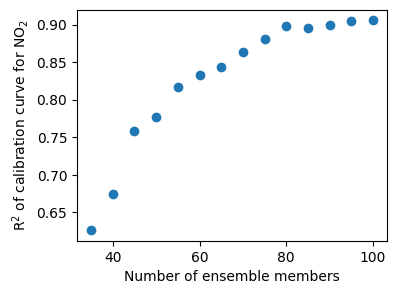

In [48]:
import seaborn as sns
plt.figure(figsize=(4,3))
plt.scatter(grids, r2s_NO2)
plt.ylabel("R$^2$ of calibration curve for NO$_2$")
plt.xlabel("Number of ensemble members")
plt.savefig('figure\\r2calibration_NO2.svg', format='svg', dpi=1200, bbox_inches="tight")
plt.show()

In [49]:
np.mean(inclusion_3pc, 1)

array([0.92232099, 0.8809465 , 0.82516461, 0.77190123, 0.72011111,
       0.67125103, 0.62296708, 0.57634568, 0.53163786, 0.48788066,
       0.44485597, 0.40125926, 0.35676132, 0.31172016, 0.2684321 ,
       0.22406584, 0.17985597, 0.1355679 , 0.09165432, 0.04833745])

In [50]:
np.mean(inclusion_11species,1)

array([0.62145342, 0.55780247, 0.50437935, 0.46140853, 0.42333221,
       0.38917284, 0.35806846, 0.32867228, 0.29997306, 0.27288777,
       0.24592144, 0.22005051, 0.19456117, 0.16875533, 0.14365544,
       0.11867116, 0.09447138, 0.07121886, 0.04740965, 0.02387654])

In [51]:
np.stack(inclusion_11species)[:,0]

array([0.89503704, 0.84624691, 0.78418519, 0.7291358 , 0.67788889,
       0.6282716 , 0.58209877, 0.53561728, 0.49332099, 0.45211111,
       0.41071605, 0.37054321, 0.32990123, 0.28862963, 0.25002469,
       0.20909877, 0.1678642 , 0.12765432, 0.08604938, 0.04362963])

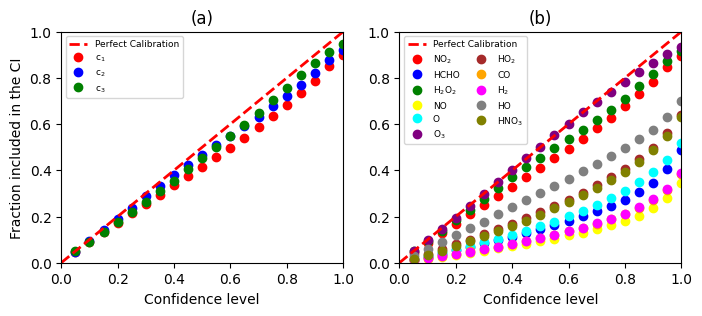

In [52]:
x_axis = ((CI_percentage[::-1]+5)/100).tolist()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (8,3))

legend_elements1 = [Line2D([0], [0], color='r', linestyle='--', lw=2, label='Perfect Calibration'),
                    Line2D([0], [0], marker='o', color='red', markerfacecolor='red', label='c$_1$', ls = ''),
                  Line2D([0], [0], marker='o', color='blue', markerfacecolor='blue', label='c$_2$', ls = ''),
                  Line2D([0], [0], marker='o', color='green', markerfacecolor='green', label='c$_3$', ls = '')]

    
ax1.set_prop_cycle(color=['red','blue','green'])


colors=['red','blue','green', 'yellow', 'cyan', 'purple', 'brown', 'orange', 'magenta', 'grey', 'olive']
specs = [ 'NO$_2$', 'HCHO', 'H$_2$O$_2$', 'NO', 'O', 'O$_3$', 'HO$_2$', 'CO', 'H$_2$', 'HO', 'HNO$_3$']
n = len(colors)

legend_elements2 = [Line2D([0], [0], color='r', linestyle='--', lw=2, label='Perfect Calibration')]

legend_elements2 += [Line2D([0], [0], marker='o', color=colors[i], markerfacecolor=colors[i], label=specs[i], ls = '') for i in range(n//2+1)]
legend_elements2 += [Patch(color=None, label='', alpha=0)]
legend_elements2 += [Line2D([0], [0], marker='o', color=colors[i], markerfacecolor=colors[i], label=specs[i], ls = '') for i in range(n//2+1, n)]
ax2.set_prop_cycle(color=colors)

for i in range(np.stack(inclusion_3pc).shape[1]):
    ax1.scatter(x_axis, np.stack(inclusion_3pc)[:,i])
for i in range(np.stack(inclusion_11species).shape[1]):
    ax2.scatter(x_axis, np.stack(inclusion_11species)[:,i])

ax1.legend(handles=legend_elements1, loc = 'upper left', prop={'size': 6.5})
ax2.legend(handles=legend_elements2, ncol = 2, prop={'size': 6.5}, columnspacing=-5)
ax1.set_ylabel("Fraction included in the CI")
ax1.set_xlabel("Confidence level")
ax2.set_xlabel("Confidence level")
ax1.set_xlim(0, 1.0)
ax2.set_xlim(0, 1.0)
ax1.set_ylim(0, 1.0)
ax2.set_ylim(0, 1.0)
ax1.set_title("(a)")
ax2.set_title("(b)")
ax1.axline((0, 0), (1, 1), linewidth=2, color='r', linestyle="--")
ax2.axline((0, 0), (1, 1), linewidth=2, color='r', linestyle="--")
# plt.show()

plt.savefig('figure\\calibration_NO2.svg', format='svg', dpi=1200, bbox_inches="tight")